# Notes on the stochastic Poisson problem: comparing ULA and MALA

*Connor Duffin*

In this note we compare the ULA algorithms to the MALA algorithms, to see how they compare. Recall that we have the measure $p(u, \theta) = p(u | \theta) p(\theta)$ in the factorized joint form, and we want to first sample from $p(\theta) = \log \mathcal{GP}(m_\theta, k_\theta)$ and use this sample to generate samples from $p(u | \theta) = \mathcal{N}(A_\theta^{-1}b, A_\theta^{-1} G A_\theta^{-\top})$.

In this case samples are generated according to a 2-step scheme:

1. Sample $\theta_k \sim p(\theta)$.
2. For $j = 1, \ldots, n_{inner}$ run a Langevin chain, sampling $u_{j, k} \dot{\sim} p(u | \theta_k)$.
3. Take the joint sample as $(u_k, \theta_k) = (u_{n_{inner}, k}, \theta_k)$.

And repeat to collect $K$ samples from the joint. The inner iterations act to ensure that the final sample is drawn from the joint, whilst also acting to decorrelate the samples. In this notebook all these parameters are set to fixed values for all samplers, to ensure fair comparisons.

In this notebook, we compare the following samplers:

1. ULA and preconditioned ULA.
2. MALA and preconditioned MALA.
3. Exact.

We will see that the preconditioned ULA sampler performs better than the MALA samplers, and comparably to the exact sampler. We will also see that due to poor conditioning, the ULA sampler fails to converge.

In [1]:
import time

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt

from sfmcmc.samplers import PoissonUnitTheta

/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/langevin-statfem/lib/python3.9/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Status size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/langevin-statfem/lib/python3.9/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Datatype size changed, may indicate binary incompatibility. Expected 24 from C header, got 32 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/langevin-statfem/lib/python3.9/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Request size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/langevin-statfem/lib/python3.9/site-packages/d

Now set up the sampler, to use the RHS uncertainty $\xi \sim \mathcal{GP}(0, \beta^2 I)$, with $\beta = 0.05$, and LHS uncertainty $\log \theta \sim \mathcal{GP}\left(1 + 0.3 \sin(\pi(x_0 + x_1), \, k_{\mathrm{se}}(x, x')\right)$, $k_{\mathrm{se}} = \rho^2 \exp(-\lVert x - x' \rVert^2 / (2\ell^2))$, $\rho = 0.1$, $\ell = 0.2$.

We also specify that we want to use the Kronecker covariance structure, and a stepsize of $\eta = 0.1$.

In [2]:
np.random.seed(27)

NX = 32
pois = PoissonUnitTheta(NX)
pois.setup_theta(0.2, 0.2, method="kronecker")

/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/langevin-statfem/lib/python3.9/site-packages/dolfin/jit/jit.py:46: RuntimeWarning: mpi4py.MPI.Status size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject
  if MPI.size(mpi_comm) == 1:
/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/langevin-statfem/lib/python3.9/site-packages/dolfin/jit/jit.py:46: RuntimeWarning: mpi4py.MPI.Datatype size changed, may indicate binary incompatibility. Expected 24 from C header, got 32 from PyObject
  if MPI.size(mpi_comm) == 1:
/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/langevin-statfem/lib/python3.9/site-packages/dolfin/jit/jit.py:46: RuntimeWarning: mpi4py.MPI.Request size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  if MPI.size(mpi_comm) == 1:
/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/langevin-statfem/lib/python3.9/site-packages/dolfin/jit/jit.py:46: RuntimeWarning: mpi4py.MPI.Prequest size changed, may indica

Let's check that the $\theta$-field is able to be sampled from appropriately:

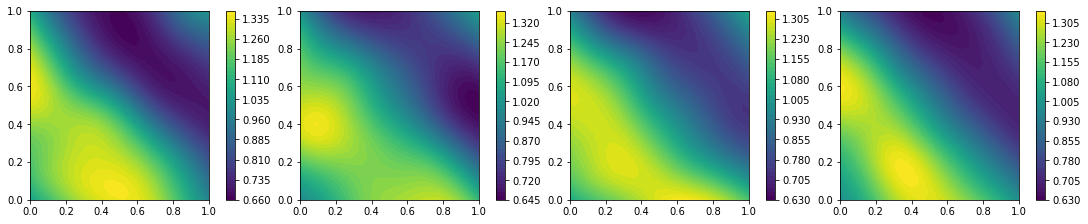

In [3]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(15, 3))

for i in range(4):
    pois.sample_theta()
    im = ax[i].tricontourf(pois.x_dofs[:, 0], 
                           pois.x_dofs[:, 1], 
                           pois.theta.vector()[:], 64)
    plt.colorbar(im, ax=ax[i])

plt.show()

And we now do some numerical checking on the use of the dense $G_\theta$ matrix:

In [4]:
pois.setup_G(scale=0.05, ell=0.2, dense=True)

z = np.random.normal(size=(pois.n_dofs, ))

%timeit -n 10 pois.G_sqrt @ z
%timeit -n 10 pois.G_inv @ z

116 µs ± 7.59 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
104 µs ± 4.36 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


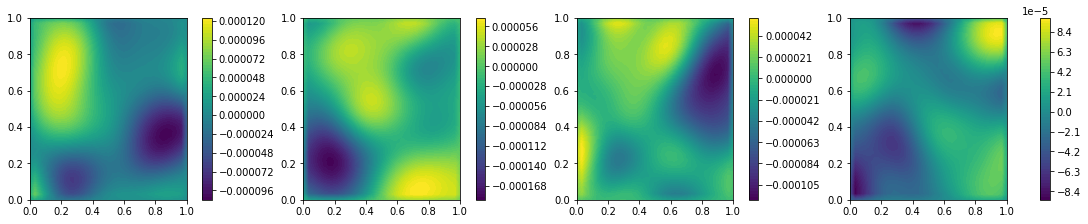

In [5]:
xi = pois.G_sqrt @ z
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(15, 3))

for i in range(4):
    z = np.random.normal(size=(pois.n_dofs, ))
    xi = pois.G_sqrt @ z
    im = ax[i].tricontourf(pois.x_dofs[:, 0], pois.x_dofs[:, 1], xi, 64)
    plt.colorbar(im, ax=ax[i])

plt.show()

Now we set some options which will be used for the rest of the simulation:


In [6]:
pois = PoissonUnitTheta(NX)
pois.setup_G(scale=0.05)
pois.setup_theta(0.2, 0.2, method="kronecker")

init = np.zeros((pois.n_dofs, ))
n_samples = 1000

Now let's run the exact sampler:

In [7]:
pois.u[:] = init
exact_samples = np.zeros((n_samples, ))

t_start = time.time()
for i in range(n_samples):
    u = pois.exact_step()
    exact_samples[i] = pois.log_target(u)
    
t_exact = time.time() - t_start

Next, we run the MALA variants, both without and with preconditioning. For the preconditioning, we use the exact Hessian.

We monitor the acceptance rates through the course of the simulation, just to be sure:

In [8]:
pois.u[:] = 0.
mala_samples = np.zeros((n_samples, ))

n_inner = 10
n_accept = 0
eta_mala = 1e-8

t_start = time.time()
for i in range(n_samples): 
    accepted = pois.mala_step(eta=eta_mala, fixed_theta=False)
    
    for j in range(n_inner):
        accepted = pois.mala_step(eta=eta_mala, fixed_theta=True)
        
    if accepted:
        n_accept += 1
        
    if i % 100 == 0:
        acceptance_ratio = n_accept / 100
        print(f" iter: {i} / {n_samples}" +
            f" last 100 iter. acc ratio: {acceptance_ratio:.2f}")
        
        n_accept = 0
    
    mala_samples[i] = pois.log_target(pois.u)
    
t_mala = time.time()

 iter: 0 / 1000 last 100 iter. acc ratio: 0.00
 iter: 100 / 1000 last 100 iter. acc ratio: 0.28
 iter: 200 / 1000 last 100 iter. acc ratio: 0.59
 iter: 300 / 1000 last 100 iter. acc ratio: 0.56
 iter: 400 / 1000 last 100 iter. acc ratio: 0.48
 iter: 500 / 1000 last 100 iter. acc ratio: 0.52
 iter: 600 / 1000 last 100 iter. acc ratio: 0.45
 iter: 700 / 1000 last 100 iter. acc ratio: 0.56
 iter: 800 / 1000 last 100 iter. acc ratio: 0.55
 iter: 900 / 1000 last 100 iter. acc ratio: 0.47


In [9]:
pois.u[:] = 0.
pmala_samples = np.zeros((n_samples, ))

eta_pmala = 1e-1
n_accept = 0
t_start = time.time()
for i in range(n_samples):
    accepted = pois.pmala_step(eta=eta_pmala)
    
    for j in range(n_inner - 1):
        accepted = pois.pmala_step(eta=eta_pmala, fixed_theta=True)
        
    if accepted:
        n_accept += 1
        
    if i % 100 == 0:
        acceptance_ratio = n_accept / 100
        print(f" iter: {i} / {n_samples}" +
            f" last 100 iter. acc ratio: {acceptance_ratio:.2f}")
        
        n_accept = 0
        
    pmala_samples[i] = pois.log_target(pois.u)

t_pmala = time.time() - t_start

 iter: 0 / 1000 last 100 iter. acc ratio: 0.00
 iter: 100 / 1000 last 100 iter. acc ratio: 0.65
 iter: 200 / 1000 last 100 iter. acc ratio: 0.67
 iter: 300 / 1000 last 100 iter. acc ratio: 0.65
 iter: 400 / 1000 last 100 iter. acc ratio: 0.72
 iter: 500 / 1000 last 100 iter. acc ratio: 0.75
 iter: 600 / 1000 last 100 iter. acc ratio: 0.67
 iter: 700 / 1000 last 100 iter. acc ratio: 0.73
 iter: 800 / 1000 last 100 iter. acc ratio: 0.59
 iter: 900 / 1000 last 100 iter. acc ratio: 0.70


Now we run a ULA sampler to show that, unfortunately, this sampler diverges due to numerical instability.

In [10]:
pois.u[:] = 0.
ula_samples = np.zeros((n_samples, ))

i_save = 0
t_start = time.time()
for i in range(n_samples):
    pois.ula_step(eta=1e-6, fixed_theta=False)
    
    for j in range(n_inner - 1):
        pois.ula_step(eta=1e-6, fixed_theta=True)
        
    if np.any(pois.u >= 1e6):
        print(f"ULA diverged at iteration {i} --- exiting")
        break
            
    ula_samples[i] = pois.log_target(pois.u)
        
t_pula = time.time() - t_start

ULA diverged at iteration 0 --- exiting


Next up, we run two preconditioned ULA samplers, both the LU preconditioning. One has a small stepsize, which we use to see what the bias looks like, for a small stepsize:

In [11]:
pois.setup_pc("lu")
pois.u[:] = 0.
pula_samples = np.zeros((n_samples, ))

eta_pula = eta_pmala
i_save = 0
t_start = time.time()
for i in range(n_samples):
    pois.pula_step_lu_mean(eta=eta_pula, fixed_theta=False)
    
    for j in range(n_inner - 1):
        pois.pula_step_lu_mean(eta=eta_pula, fixed_theta=True)
        
    pula_samples[i] = pois.log_target(pois.u)
        
t_pula = time.time() - t_start

In [12]:
pois.setup_pc("lu")
pois.u[:] = 0.
pula_samples_small = np.zeros((n_samples, ))

i_save = 0
t_start = time.time()
for i in range(n_samples):
    pois.pula_step_lu_mean(eta=1e-3, fixed_theta=False)
    
    for j in range(n_inner - 1):
        pois.pula_step_lu_mean(eta=1e-3, fixed_theta=True)
        
    pula_samples_small[i] = pois.log_target(pois.u)
        
t_pula_inner = time.time() - t_start

We can visualise the bias as below, using the evaluations of the log-likelihood. With the small stepsize it takes a while to converge, in comparison to the other samplers. However, for this example, we still perform better than MALA, which fails to converge to the true stationary measure (this is due to poor conditioning).

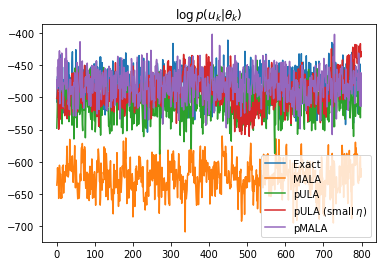

In [13]:
n_warmup = 200

plt.plot(exact_samples[n_warmup:], label="Exact")
plt.plot(mala_samples[n_warmup:], label="MALA")
plt.plot(pula_samples[n_warmup:], label="pULA")
plt.plot(pula_samples_small[n_warmup:], label=r"pULA (small $\eta$)")
plt.plot(pmala_samples[n_warmup:], label="pMALA")
plt.title(r"$\log p(u_k | \theta_k)$")
plt.legend()
plt.show()

And we can compare the runtimes:

In [14]:
print(t_pmala)
print(t_pula)
print(t_exact)

5.807622671127319
2.8843770027160645
3.0572383403778076


So the ULA sampler is very similar to the efficient exact sampler, and is faster than the MALA sampler. Which is nice! But expected as we use an exact preconditioner for the MALA, and it has to do the Metropolis correction. Next up we check the effective sample sizes of each:

In [15]:
import arviz as az

print(az.ess(pula_samples[n_warmup:]))
print(az.ess(pmala_samples[n_warmup:]))
print(az.ess(exact_samples[n_warmup:]))

629.318136734289
467.03692281715786
851.8147208042093


Finally, let's check to see whether the inner iterations do, in fact, decorrelate the samples (as well as see the effect of the stepsize, on correlation):

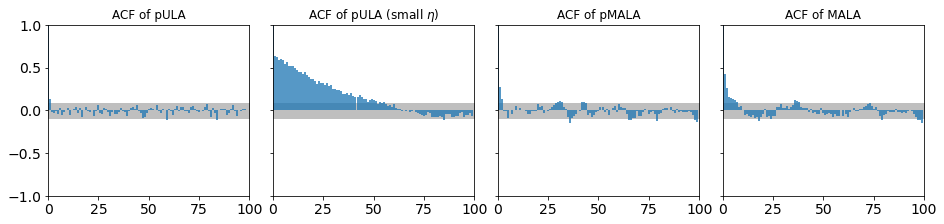

In [16]:
n_warmup = 500
fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(13, 3), sharey=True)
az.plot_autocorr(pula_samples[n_warmup:], ax=axs[0])
axs[0].set_title("ACF of pULA")

az.plot_autocorr(pula_samples_small[n_warmup:], ax=axs[1])
axs[1].set_title(r"ACF of pULA (small $\eta$)")

az.plot_autocorr(pmala_samples[n_warmup:], ax=axs[2])
axs[2].set_title("ACF of pMALA")

az.plot_autocorr(mala_samples[n_warmup:], ax=axs[3])
axs[3].set_title("ACF of MALA")
plt.show()

So we can see that $n_{inner} = 10$ seems to decorrelate the samples for $\eta = 0.1$, but fails to do so for $\eta = 10^{-3}$. So there seems to be a tradeoff between the inner iterations and the stepsize: see the whitepaper for some more analysis of this.